# G.1 - Additonal Explorations - User Related Explorations

This notebooks contains additional explorations of our data and network, whose results were not included in the paper. This notebook specifically focuses on user related and oriented explorations. As we chose to focus on a goal centered network, and have little data about our users, we chose not to include these explorations in our paper.

In [1]:
# importing relevant packages
from tqdm import tqdm
import re
import json
import ijson
import matplotlib.pyplot as plt
from collections import Counter

## Exploration of Followers

On the DayZero Project platform, users can follow one another. To consider whether exploring the influence of followership on our network might be interesting, we first wanted to see how popular this function is on the website.

To do this, we first created a dictionary of users and followers, using the html data scraped for each users' goals list, which includes a small bio about each user that contains, at minimum, the user's username, followers and following counts.

As the list containing the html files is around 10GB large, we need to do this computationally efficient.

In [2]:
user_follow_dict = {}

# Precompile regex for faster extraction (optional)
followers_re = re.compile(r'<div class="profile-followerscount">(\d+)</div>')
following_re = re.compile(r'<div class="profile-followingcount">(\d+)</div>')

# Open the large JSON file
with open("goal_lists_html_list.json", "r", encoding="utf-8") as f:
    # ijson.items yields each item in the top-level array one by one
    items = ijson.items(f, "item")
    
    for item in tqdm(items, desc="Extracting followers/following"):
        username = item.get("username")
        html = item.get("html")

        # Skip invalid entries
        if not username or not isinstance(html, str):
            continue

        # Using regex 
        followers_match = followers_re.search(html)
        following_match = following_re.search(html)

        followerscount = int(followers_match.group(1)) if followers_match else 0
        followingcount = int(following_match.group(1)) if following_match else 0

        user_follow_dict[username] = {
            "followerscount": followerscount,
            "followingcount": followingcount
        }

print(f"Extracted follower/following counts for {len(user_follow_dict)} users.")

Extracting followers/following: 15205it [01:25, 178.85it/s]


Extracted follower/following counts for 12997 users.


Now we can check the maximum amount of followers and people followed any users has, and how many users have no followers of follow no one.

In [3]:
followers_list = [v["followerscount"] for v in user_follow_dict.values()]
following_list = [v["followingcount"] for v in user_follow_dict.values()]

max_followers = max(followers_list)
max_following = max(following_list)
zero_followers = sum(1 for x in followers_list if x == 0)
zero_following = sum(1 for x in following_list if x == 0)

print(f"Max followers: {max_followers}")
print(f"Max following: {max_following}")
print(f"Users with 0 followers: {zero_followers}")
print(f"Users with 0 following: {zero_following}")

Max followers: 91
Max following: 232
Users with 0 followers: 10661
Users with 0 following: 12210


As can be seen above, the maximum amount of followers any of our users has is 91, which is relatively low considering that there are tens of thousands of users on the platform. The maximum amount of people followed by any of our users is 232, which is also quite little. Overall, 10661 (82%) of our users have no followers, and 12210 (94%) do not follow any other users. Considering that how large these percentages are, we concluded that an analysis including followership is not relevant for our paper.

We again export the results for safekeeping and easier access.

In [4]:
# Export counts_clean_dict
with open("user_follow_dict.json", "w", encoding="utf-8") as f:
    json.dump(user_follow_dict, f, ensure_ascii=False, indent=2)

## Exploration of the Lengths of Users' Goal Lists

Another consideration was to explore the length of users's goal list, as this could potentially indirectly influence some of the measures used in our network. 

To do so, we worked with the user_goals dictionary, containing user name as key and goals of the user as values (nested dict with ID, href and text of goal). 

In [5]:
with open("user_goals.json", "r") as f:
    user_goals = json.load(f)

In [6]:
len(user_goals)

12997

To explore the lengths, we checked how many users' lists had no goals on them and used a histogram for all list of length more than zero.

In [7]:
count_zero = sum(1 for items in user_goals.values() if len(items) == 0)
print(count_zero)

2910


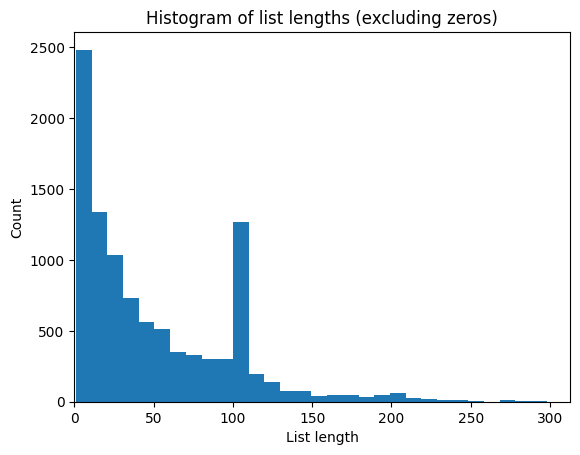

In [8]:
# Extract lengths excluding zeros
lengths = [len(items) for items in user_goals.values() if len(items) > 0]

plt.hist(lengths, bins=30)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("List length")
plt.ylabel("Count")
plt.title("Histogram of list lengths (excluding zeros)")
plt.show()

As can be seen in the histogram, most users have relatively short lists. There is also a significant amount just above 100. This has to do with a feature of the platform, that encourages lists of length 101 (the idea behind this is to complete 101 goals in 1001 days). To confirm the visual findings, we can look at the lengths ordered by frequency below.

In [9]:
length_counts = Counter(lengths)

for length, count in length_counts.most_common(10):
    print(f"{length:>8}  ->  {count}")

     101  ->  718
       1  ->  531
       2  ->  330
       3  ->  301
       4  ->  232
       5  ->  214
       6  ->  193
      10  ->  192
       8  ->  176
       7  ->  166


The printed output above confirms that 101 is the most popular length for lists, followed by very short lists of length one, two, three, four, five and six.